
# Model-based and sequential feature selection

This example illustrates and compares two approaches for feature selection:
:class:`~sklearn.feature_selection.SelectFromModel` which is based on feature
importance, and
:class:`~sklearn.feature_selection.SequentialFeatureSelector` which relies
on a greedy approach.

We use the Diabetes dataset, which consists of 10 features collected from 442
diabetes patients.

Authors: [Manoj Kumar](mks542@nyu.edu),
[Maria Telenczuk](https://github.com/maikia), Nicolas Hug.

License: BSD 3 clause


## Loading the data

We first load the diabetes dataset which is available from within
scikit-learn, and print its description:



In [8]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

## Feature importance from coefficients

To get an idea of the importance of the features, we are going to use the
:class:`~sklearn.linear_model.RidgeCV` estimator. The features with the
highest absolute `coef_` value are considered the most important.
We can observe the coefficients directly without needing to scale them (or
scale the data) because from the description above, we know that the features
were already standardized.
For a more complete example on the interpretations of the coefficients of
linear models, you may refer to
`sphx_glr_auto_examples_inspection_plot_linear_model_coefficient_interpretation.py`.  # noqa: E501



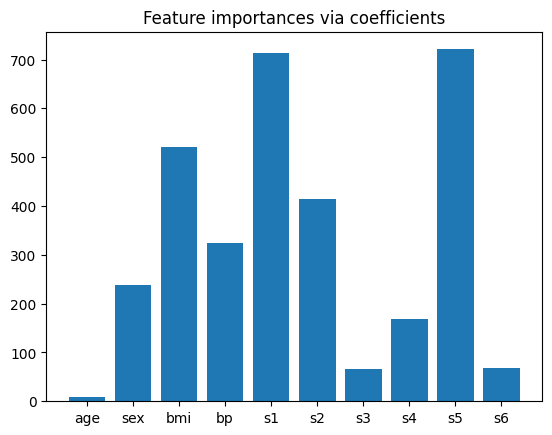

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

## Selecting features based on importance

Now we want to select the two features which are the most important according
to the coefficients. The :class:`~sklearn.feature_selection.SelectFromModel`
is meant just for that. :class:`~sklearn.feature_selection.SelectFromModel`
accepts a `threshold` parameter and will select the features whose importance
(defined by the coefficients) are above this threshold.

Since we want to select only 2 features, we will set this threshold slightly
above the coefficient of third most important feature.



### Explanation of `SelectFromModel` in scikit-learn

The `SelectFromModel` class in `scikit-learn` is a meta-transformer that uses the importance weights of an estimator to select features based on a specified threshold.

#### Purpose

The main goal of `SelectFromModel` is to select features that are considered important by a pre-trained model, thereby reducing the dimensionality of the dataset while retaining the most informative features.

#### Process

1. **Train an Estimator**:
   - First, an estimator is trained on the dataset. In the provided example, a `RidgeCV` estimator is used:
     ```python
     ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
     ```

2. **Compute Feature Importance**:
   - The importance of each feature is derived from the trained estimator. For linear models like `RidgeCV`, the importance is typically based on the absolute values of the coefficients:
     $$ \text{importance} = |\beta_i| $$
     where $\beta_i$ are the coefficients of the linear model.

3. **Set Threshold**:
   - A threshold is set to determine which features are considered important. In the example:
     ```python
     threshold = np.sort(importance)[-3] + 0.01
     ```
     This sets the threshold slightly above the third highest importance score, ensuring that only the top 3 features are selected.

4. **Feature Selection**:
   - `SelectFromModel` uses the pre-trained estimator and the threshold to select features:
     ```python
     sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
     ```
     Features with importance scores above the threshold are retained.

#### Mathematical Foundation

- **Importance Calculation**:
  For linear models, feature importance can be directly obtained from the model's coefficients. For tree-based models, feature importance is derived from the reduction in impurity (e.g., Gini impurity or entropy).

- **Thresholding**:
  The thresholding process involves comparing each feature's importance score against the specified threshold:
  $$ \text{Selected Features} = \{X_i \,|\, |\beta_i| > \text{threshold} \} $$

#### Main Arguments

- `estimator`: The pre-trained model that provides the feature importance scores.
- `threshold`: The threshold value for feature importance. Features with importance scores above this value are selected. It can be a numeric value or a string (e.g., "mean", "median").

#### Interpretation of Results

- `get_support()`: Returns a boolean mask indicating which features are selected.
- `transform(X)`: Reduces the dataset to the selected features.
- The selected features are those deemed most important by the estimator based on the specified threshold.



In [10]:
from time import time

from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-3] + 0.01

tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['s1' 's5']
Done in 0.003s


## Selecting features with Sequential Feature Selection

Another way of selecting features is to use
:class:`~sklearn.feature_selection.SequentialFeatureSelector`
(SFS). SFS is a greedy procedure where, at each iteration, we choose the best
new feature to add to our selected features based a cross-validation score.
That is, we start with 0 features and choose the best single feature with the
highest score. The procedure is repeated until we reach the desired number of
selected features.

We can also go in the reverse direction (backward SFS), *i.e.* start with all
the features and greedily choose features to remove one by one. We illustrate
both approaches here.



### Explanation of Forward Sequential Feature Selector

The `SequentialFeatureSelector` class in `scikit-learn` is a wrapper feature selection method that selects features sequentially based on their contribution to the model's performance. There are two main strategies: forward selection and backward selection. Here, we focus on forward sequential selection.

#### Forward Sequential Selection Process

1. **Initialization**:
   - Start with an empty set of selected features.

2. **Iteration**:
   - At each iteration, evaluate each feature not yet selected by adding it to the set of selected features and training the model.
   - Compute the performance metric for each model with the added feature.

3. **Selection**:
   - Select the feature that results in the best performance improvement and add it to the set of selected features.

4. **Repeat**:
   - Repeat the process until the desired number of features is selected.

#### Mathematical Computation

For each iteration:
1. **Model Training**:
   - Train the model using the current set of selected features plus one additional feature.
   
2. **Performance Evaluation**:
   - Compute the performance metric (e.g., mean squared error for regression, accuracy for classification) for each model.
   - For `RidgeCV`, this involves minimizing the cross-validated mean squared error:
     $$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$
   - The feature that results in the lowest MSE is selected.

3. **Feature Addition**:
   - Add the best-performing feature to the set of selected features.

#### Main Arguments

- `estimator`: The model used to evaluate the feature sets. In this case, `RidgeCV` is used.
- `n_features_to_select`: The number of features to select. Here, it is set to 2.
- `direction`: The direction of the selection process. For forward selection, it is `"forward"`. For backward selection, it is `"backward"`.


In [11]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="forward"
).fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="backward"
).fit(X, y)
toc_bwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: ['bmi' 's5']
Done in 0.141s
Features selected by backward sequential selection: ['bmi' 's5']
Done in 0.372s


Interestingly, forward and backward selection have selected the same set of
features. In general, this isn't the case and the two methods would lead to
different results.

We also note that the features selected by SFS differ from those selected by
feature importance: SFS selects `bmi` instead of `s1`. This does sound
reasonable though, since `bmi` corresponds to the third most important
feature according to the coefficients. It is quite remarkable considering
that SFS makes no use of the coefficients at all.

To finish with, we should note that
:class:`~sklearn.feature_selection.SelectFromModel` is significantly faster
than SFS. Indeed, :class:`~sklearn.feature_selection.SelectFromModel` only
needs to fit a model once, while SFS needs to cross-validate many different
models for each of the iterations. SFS however works with any model, while
:class:`~sklearn.feature_selection.SelectFromModel` requires the underlying
estimator to expose a `coef_` attribute or a `feature_importances_`
attribute. The forward SFS is faster than the backward SFS because it only
needs to perform `n_features_to_select = 2` iterations, while the backward
SFS needs to perform `n_features - n_features_to_select = 8` iterations.

## Using negative tolerance values

:class:`~sklearn.feature_selection.SequentialFeatureSelector` can be used
to remove features present in the dataset and return a
smaller subset of the original features with `direction="backward"`
and a negative value of `tol`.

We begin by loading the Breast Cancer dataset, consisting of 30 different
features and 569 samples.



In [12]:
import numpy as np

from sklearn.datasets import load_breast_cancer

breast_cancer_data = load_breast_cancer()
X, y = breast_cancer_data.data, breast_cancer_data.target
feature_names = np.array(breast_cancer_data.feature_names)
print(breast_cancer_data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

We will make use of the :class:`~sklearn.linear_model.LogisticRegression`
estimator with :class:`~sklearn.feature_selection.SequentialFeatureSelector`
to perform the feature selection.



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

for tol in [-1e-2, -1e-3, -1e-4]:
    start = time()
    feature_selector = SequentialFeatureSelector(
        LogisticRegression(),
        n_features_to_select="auto",
        direction="backward",
        scoring="roc_auc",
        tol=tol,
        n_jobs=2,
    )
    model = make_pipeline(StandardScaler(), feature_selector, LogisticRegression())
    model.fit(X, y)
    end = time()
    print(f"\ntol: {tol}")
    print(f"Features selected: {feature_names[model[1].get_support()]}")
    print(f"ROC AUC score: {roc_auc_score(y, model.predict_proba(X)[:, 1]):.3f}")
    print(f"Done in {end - start:.3f}s")


tol: -0.01
Features selected: ['worst perimeter']
ROC AUC score: 0.975
Done in 16.131s


We can see that the number of features selected tend to increase as negative
values of `tol` approach to zero. The time taken for feature selection also
decreases as the values of `tol` come closer to zero.

